<a href="https://colab.research.google.com/github/mohit0305/Image_segmentation/blob/main/Segmentation_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/seg.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

image_path = os.path.join("/tmp/seg/images")
mask_path = os.path.join("/tmp/seg/masks")


In [ ]:
images = os.listdir(image_path)
mask = os.listdir(mask_path)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

In [ ]:
check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:",len(check))

Total mask that has modified name: 0


In [ ]:
testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))
training_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))

def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    
    if flag == "test":
        for i in tqdm(testing_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i)),(X_shape,X_shape))[:,:,0]
            
            im_array.append(im)
            mask_array.append(mask)
        
        return im_array,mask_array
    
    if flag == "train":
        for i in tqdm(training_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i.split("_mask")[0]+".png")),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i+".png")),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array

In [ ]:
def plotMask(X,y):
    sample = []
    
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])
        
        plt.show()

In [ ]:
dim = 256*2
X_train,y_train = getData(dim)
X_test, y_test = getData(dim)

100%|██████████| 500/500 [00:02<00:00, 234.00it/s]


training set


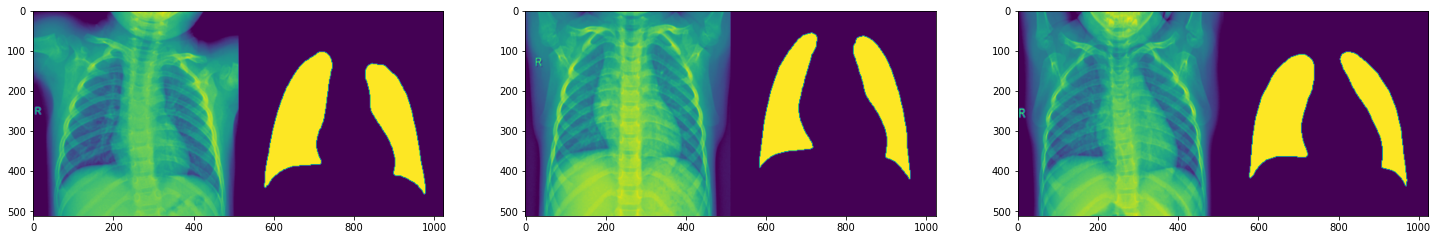

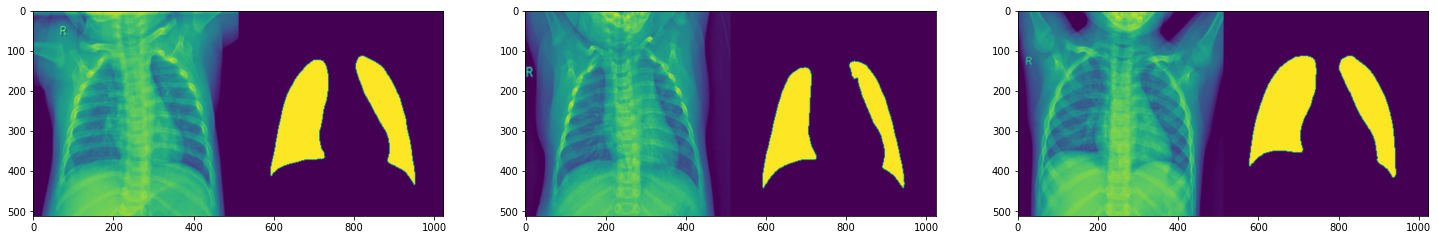

testing set


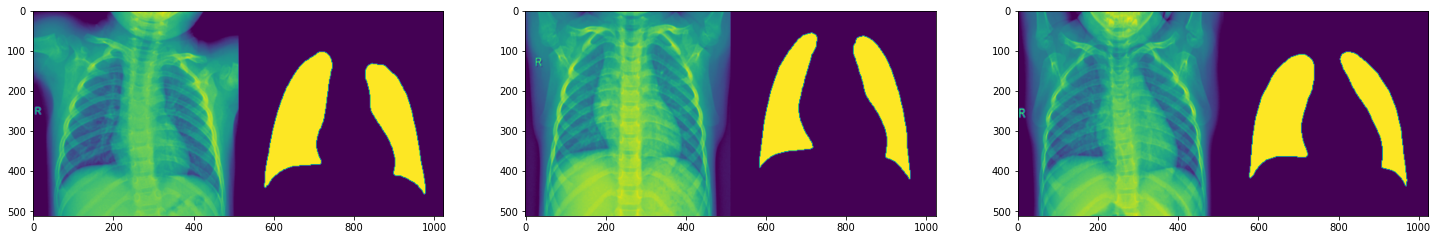

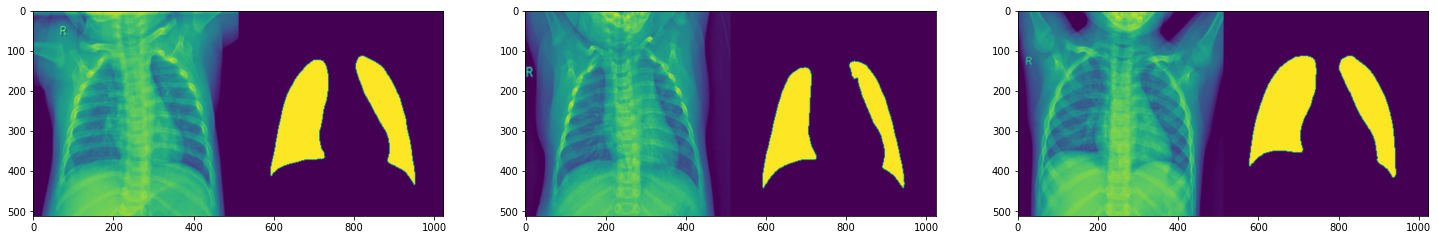

In [ ]:
print("training set")
plotMask(X_train,y_train)
print("testing set")
plotMask(X_test,y_test)

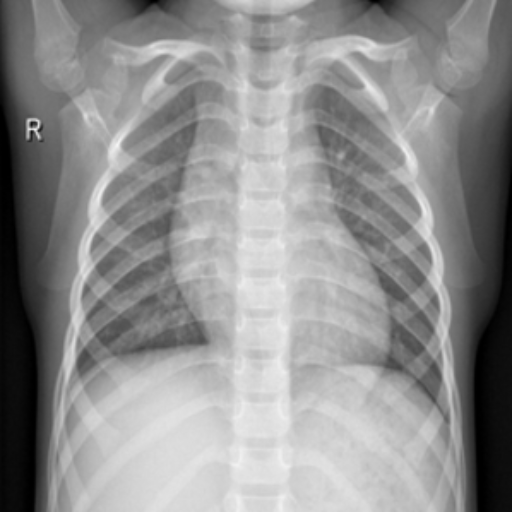

In [ ]:
from google.colab.patches import cv2_imshow
X_train = np.array(X_train).reshape(len(X_train),dim,dim,1)
y_train = np.array(y_train).reshape(len(y_train),dim,dim,1)
X_test = np.array(X_test).reshape(len(X_test),dim,dim,1)
y_test = np.array(y_test).reshape(len(y_test),dim,dim,1)
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape
images = (X_train)
mask  = (y_train)
cv2_imshow(images[1])


In [ ]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from tensorflow.keras.optimizers import Adam
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
model = unet(input_size=(512,512,1))
model.compile(optimizer = Adam(lr=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
from IPython.display import clear_output
#from keras.optimizers import Adam 
from sklearn.model_selection import train_test_split

model.compile(optimizer=Adam(lr=2e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy'])
train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0, (mask>127).astype(np.float32), test_size = 0.5,random_state = 2018)
train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, test_size = 0.5, random_state = 2018)

loss_history = model.fit(x = train_vol,
                       y = train_seg,
                         batch_size = 16,
                  epochs = 30,
                  validation_data =(test_vol,test_seg) ,
                  callbacks=callbacks_list)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: -0.2958 - dice_coef: 0.2957 - binary_accuracy: 0.6552
Epoch 1: val_loss improved from inf to -0.29918, saving model to cxr_reg_weights.best.hdf5
8/8 [==============================] - 25s 3s/step - loss: -0.2958 - dice_coef: 0.2957 - binary_accuracy: 0.6552 - val_loss: -0.2992 - val_dice_coef: 0.2994 - val_binary_accuracy: 0.6437 - lr: 2.0000e-04
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: -0.3005 - dice_coef: 0.3006 - binary_accuracy: 0.6297
Epoch 2: val_loss improved from -0.29918 to -0.30774, saving model to cxr_reg_weights.best.hdf5
8/8 [==============================] - 12s 2s/step - loss: -0.3005 - dice_coef: 0.3006 - binary_accuracy: 0.6297 - val_loss: -0.3077 - val_dice_coef: 0.3080 - val_binary_accuracy: 0.6468 - lr: 2.0000e-04
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: -0.3163 - dice_coef: 0.3166 - binary_accuracy: 0.6357
Epoch 3: val_loss improved from -0.30774 to -

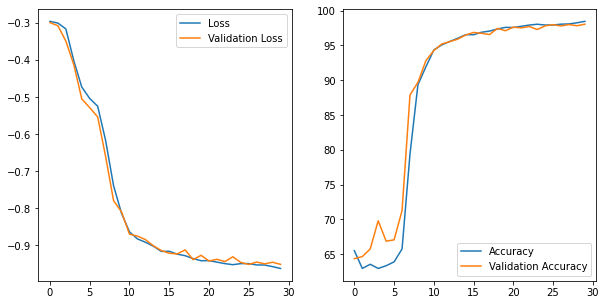

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

(250, 512, 512, 1)


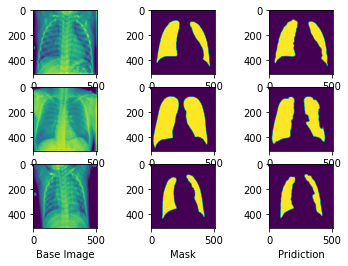

In [ ]:
print(validation_vol.shape)
pred_candidates = np.random.randint(1,validation_vol.shape[0],10)
preds = model.predict(validation_vol)


for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]))
    plt.xlabel("Base Image")
    
    
    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]))
    plt.xlabel("Mask")
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]))
    plt.xlabel("Pridiction")

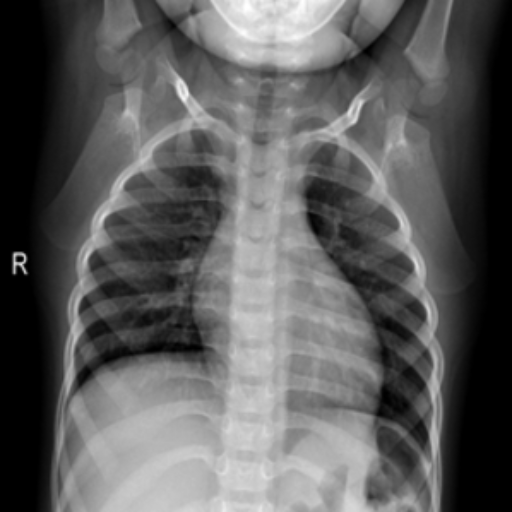

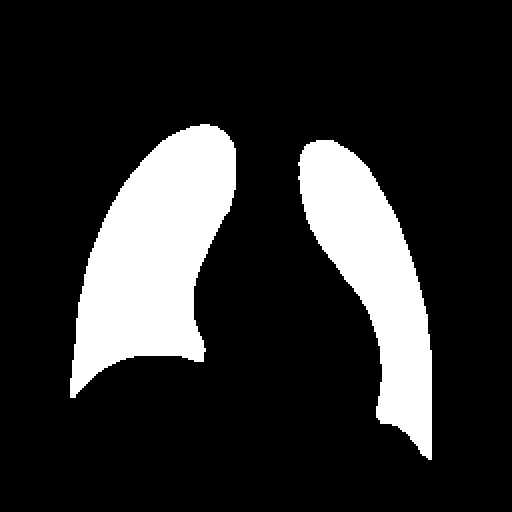

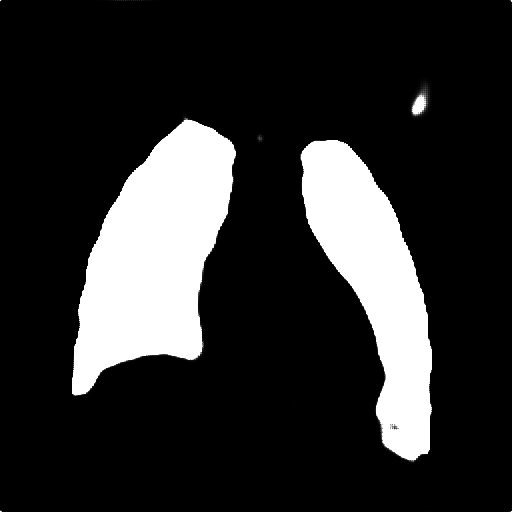

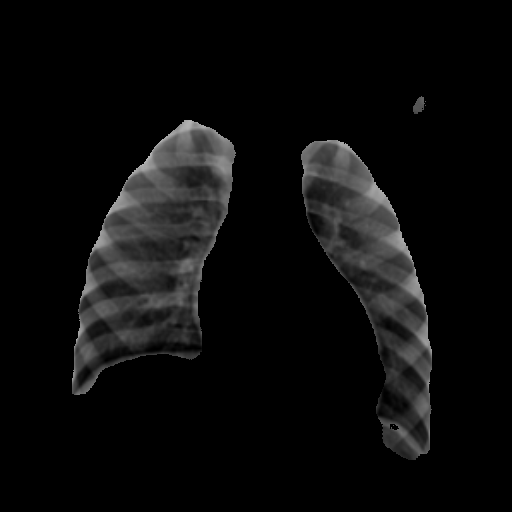

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [ ]:
import cv2
img = (np.squeeze(validation_vol[pred_candidates[1]])*127) + 127
mas = np.squeeze(validation_seg[pred_candidates[1]])*127
pred = np.squeeze(preds[pred_candidates[1]])*127
pred_lung = cv2.bitwise_and(img,img, mask=pred.astype(np.uint8))
cv2_imshow(img)
cv2_imshow((mas*255))
cv2_imshow((pred*255))
cv2_imshow(pred_lung)
plt.figure(figsize=(20,10))


In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models
from skimage.io import imread
from skimage.transform import resize
import cv2

In [ ]:
class GradCamModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.gradients = None
        self.tensorhook = []
        self.layerhook = []
        self.selected_out = None
        #layer5 = layer4.2.relu
        #PRETRAINED MODEL
        self.pretrained = models.resnet101(pretrained=True)
        self.layerhook.append(self.pretrained.layer4.register_forward_hook(self.forward_hook()))
        
        for p in self.pretrained.parameters():
            p.requires_grad = True
    
    def activations_hook(self,grad):
        self.gradients = grad

    def get_act_grads(self):
        return self.gradients

    def forward_hook(self):
        def hook(module, inp, out):
            self.selected_out = out
            self.tensorhook.append(out.register_hook(self.activations_hook))
        return hook

    def forward(self,x):
        out = self.pretrained(x)
        return out, self.selected_out

In [ ]:
gcmodel = GradCamModel()

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

(224, 224, 3)


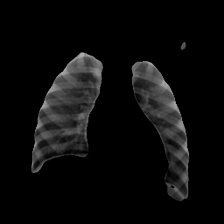

(224, 224, 3)


In [ ]:
from skimage.color import gray2rgb
from google.colab.patches import cv2_imshow
#img = imread('/tmp/cam/Normal/Normal-19.png') #'bulbul.jpg'
img = pred_lung
img = gray2rgb(img)
#im = img
#img = img[50:249, 50:249]
img = resize(img, (224,224), preserve_range = True)
print(img.shape)
cv2_imshow(img)
print(img.shape)
img = np.expand_dims(img.transpose((2,0,1)),0)
img /= 255.0
mean = np.array([0.485, 0.456, 0.406]).reshape((1,3,1,1))
std = np.array([0.229, 0.224, 0.225]).reshape((1,3,1,1))
img = ((img) - (mean))/std
inpimg = torch.from_numpy(img).to( torch.float32)

torch.Size([1, 2048, 7, 7])


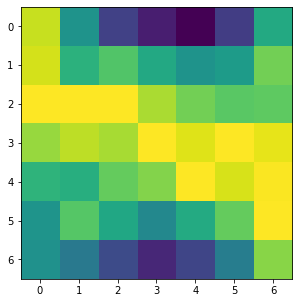

torch.Size([7, 7])


In [ ]:
out, acts = gcmodel(inpimg)
acts = acts.detach().cpu()
loss = nn.CrossEntropyLoss()(out,torch.from_numpy(np.array([500])))
loss.backward()
grads = gcmodel.get_act_grads().detach().cpu()
print(grads.shape)
pooled_grads = torch.mean(grads, dim=[0,2,3]).detach().cpu()
for i in range(acts.shape[1]):
 acts[:,i,:,:] += pooled_grads[i]

heatmap_j = torch.mean(acts, dim = 1).squeeze()
heatmap_j_max = heatmap_j.max(axis = 0)[0]
heatmap_j /= heatmap_j_max
fig, axs = plt.subplots(1,1,figsize = (5,5))
axs.imshow(heatmap_j)
plt.show()
print(heatmap_j.shape)

In [ ]:
#heatmap_j = resize(heatmap_j,(224,224),preserve_range=True)
#fig, axs = plt.subplots(1,1,figsize = (5,5))
#axs.imshow(heatmap_j)
#plt.show()
#print(heatmap_j.shape)
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow
#img = cv2.imread('/tmp/cam/Normal/Normal-11.png')
#im = im[40:249, 40:249]
#print(im.shape)
#heatmap = cv2.resize(heatmap,(299,299))
#img = resize(img,(299,299),preserve_range=True)
print(img.shape)
img = img [0,0,:,:]
cv2_imshow(img)
heatmap = resize(heatmap_j,(224,224),preserve_range=True)
heatmap = cv2.applyColorMap(np.uint8(255 * (255 - heatmap)), cv2.COLORMAP_JET)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
#heatmap = heatmap [:,:,0]
print(heatmap.shape)
#fig, axs = plt.subplots(1,1,figsize = (5,5))
#axs.imshow(heatmap)
#plt.show()
superimposed_img = heatmap*0.56 + img*0.8
cv2.imwrite('./map.jpg', superimposed_img)
image = cv2.imread('./map.jpg')
image = resize(image,(299,299),preserve_range=True)
#image = cv2.resize(image, (50,))
cv2_imshow(image)

(224, 224)


IndexError: ignored